In [1]:
%%capture setup_output
%run 'setup.ipynb'

# run the following command to get the output of the setup commands
# setup_output.show()

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.preprocessing import StandardScaler

from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor

import torch
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from torch import nn
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
import matplotlib.pyplot as plt
from src.LSTMModel import LSTMModel
from src.plot_results import plot_regression_results, plot_average_error_by_bins, plot_prediction_distribution
from src.metrics.evaluate import evaluate_regression, compute_median_80_percent_error

In [3]:
sequence_length = 4
batch_size = 1024

# Define dataset file path
file_path = '../results/removed_outliers.parquet'
df = pd.read_parquet(file_path)

# Define features and target variables
relevant_features = ['c_vin', 'c_realstartsoc', 'weekday_numerical', 'is_weekend',
                     'mean_consumption', 'mean_duration', 'latitude', 'longitude',
                     'start_hour', 'start_day', 'is_home_spot', 'is_location_one',
                     'start_datetime', 'delta_soc_real', 'plugin_duration_hr']

target = 'delta_soc_real' #, 'delta_soc_real', plugin_duration_hr

df = df[relevant_features]

In [4]:
print(len(df))
df = df.dropna()
print(len(df))

8637446
8631511


In [25]:
df['c_vin'].nunique()

27573

In [6]:
# Sort the DataFrame by 'c_vin' and 'start_datetime'
df = df.sort_values(by=['c_vin', 'start_datetime'])

# Add new features for previous session plugin_duration_hr and delta_soc_real
df['prev_plugin_duration_hr'] = df.groupby('c_vin')['plugin_duration_hr'].shift(1)
df['prev_delta_soc_real'] = df.groupby('c_vin')['delta_soc_real'].shift(1)

# Fill missing prev values with current
df['prev_plugin_duration_hr'] = df['prev_plugin_duration_hr'].fillna(df['plugin_duration_hr'])
df['prev_delta_soc_real'] = df['prev_delta_soc_real'].fillna(df['delta_soc_real'])

In [7]:
label_encoder = LabelEncoder()
df['c_vin_encoded'] = label_encoder.fit_transform(df['c_vin'])

features = ['c_realstartsoc', 'weekday_numerical', 'is_weekend',
            'mean_consumption', 'mean_duration', 'latitude', 'longitude',
            'start_hour', 'start_day', 'is_home_spot', 'is_location_one',
            'prev_plugin_duration_hr', 'prev_delta_soc_real']

In [8]:
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

df[features] = feature_scaler.fit_transform(df[features])
df[[target]] = target_scaler.fit_transform(df[[target]])

In [9]:
def process_group(group):
    try:
        group = group.sort_values('start_datetime')
        sequences = []
        targets = []
        vins = []
        for i in range(len(group) - sequence_length):
            sequence = group[features].iloc[i:i + sequence_length].values
            target_value = group[target].iloc[i + sequence_length]
            vin_value = group['c_vin_encoded'].iloc[0]
            sequences.append(sequence)
            targets.append(target_value)
            vins.append(vin_value)
    except Exception as e:
        print(f"Error processing group {group['c_vin'].iloc[0]}: {e}")
    return sequences, targets, vins

In [10]:
# Creates multiple processes to create user sequences faster
with ProcessPoolExecutor(max_workers=31) as executor:
    results = list(executor.map(process_group, [group for _, group in df.groupby('c_vin')]))

In [11]:
merged_X = []
merged_y = []
merged_vin = []

for X, y, vin in results:
    merged_X.extend(X)
    merged_y.extend(y)
    merged_vin.extend(vin)

merged_X = np.array(merged_X)
merged_y = np.array(merged_y)
merged_vin = np.array(merged_vin)

In [12]:
# The user sequences can be either shuffled or split
# sequencially to avoid having parts of the same sequence in the train and test sets

# Option 1 of splitting the dataset
X_train, X_temp, y_train, y_temp, vin_train, vin_temp = train_test_split(
    merged_X, merged_y, merged_vin, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test, vin_val, vin_test = train_test_split(
    X_temp, y_temp, vin_temp, test_size=0.5, random_state=42)

# Option 2 of splitting the dataset

# train_size = int(0.2 * len(merged_X))
# val_size = int(0.02 * len(merged_X))
# X_train, X_val, X_test = merged_X[:train_size], merged_X[train_size:train_size + val_size], merged_X[train_size + val_size:]
# y_train, y_val, y_test = merged_y[:train_size], merged_y[train_size:train_size + val_size], merged_y[train_size + val_size:]
# vin_train, vin_val, vin_test = merged_vin[:train_size], merged_vin[train_size:train_size + val_size], merged_vin[train_size + val_size:]

In [13]:
# Make sure the dimensions are the same for different sets
print(f"X_train: {len(X_train)}, X_val: {len(X_val)}, X_test: {len(X_test)}")
print(f"y_train: {len(y_train)}, y_val: {len(y_val)}, y_test: {len(y_test)}")
print(f"vin_train: {len(vin_train)}, vin_val: {len(vin_val)}, vin_test: {len(vin_test)}")

6817069 852134 852134
6817069 852134 852134
6817069 852134 852134


In [14]:
unique_values = set(vin_test)
num_unique_values = len(unique_values)
print(f"The number of unique values in the list is: {num_unique_values}")

The number of unique values in the list is: 27452


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ', device)

Device:  cuda


In [16]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
vins_train = np.array(vin_train)
vins_val = np.array(vin_val)
vins_test = np.array(vin_test)

In [17]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32).unsqueeze(1))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32).unsqueeze(1))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=31)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=31)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [18]:
# Set up logger
csv_logger = CSVLogger("logs", name="lstm-dur")

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints-lstm',
    filename='best_checkpoint_soc',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, mode="min")

In [19]:
model = LSTMModel(sequence_length=sequence_length,
                  num_features=len(features),
                  dropout_rate=0.05)

trainer = pl.Trainer(max_epochs=75,
                     logger=csv_logger,
                     callbacks=[checkpoint_callback, early_stopping],
                     gradient_clip_val=1.0)
# trainer.fit(model, train_loader, val_loader)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.05 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [20]:
checkpoint_path = 'checkpoints-lstm/best_checkpoint_soc-v38.ckpt'
model = LSTMModel.load_from_checkpoint(checkpoint_path,
                                       sequence_length=sequence_length,
                                       num_features=len(features))


In [21]:
trainer.test(model, test_loader)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.7839087843894958     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7839087843894958}]

In [22]:
model.eval()
# model.to(device)
with torch.no_grad():
    y_pred = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()


In [23]:
y_pred_original = target_scaler.inverse_transform(y_pred)
y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1))

Mean Absolute Error(MAE): 0.720578289526002
Median Absolute Error(MAE): 0.630539344994762
Root Mean Squared Error(MAE): 0.8853863139558538
Mean Absolute Error(MAE) original: 15.972749768342561
Median Absolute Error(MAE) original: 13.976895332336428
Root Mean Squared Error(MAE) original: 19.62597854259534


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [25]:
metrics = evaluate_regression(y_test_original, y_pred_original)
print("Evaluation Metrics:", metrics)

Evaluation Metrics: {'MAE': 15.972749768342561, 'MSE': 385.1790337544127, 'RMSE': 19.62597854259534, 'R2': 0.2106736211043081, 'MAPE': 115.84709162164229, 'Positive MAPE ': 27.427141784771372, 'Negative MAPE ': -195.4852183716952, 'MNE': -15.34450869421859, 'MPE': 16.670267986392144, 'Pinball Loss': 7.9343004321442745, 'Coverage Accuracy': 52.61273461685604}


In [26]:
median_80_error = compute_median_80_percent_error(y_test_original, y_pred_original)
print(f"Median 80% Average Error: {median_80_error}")

Median 80% Average Error: 13.981941223144531


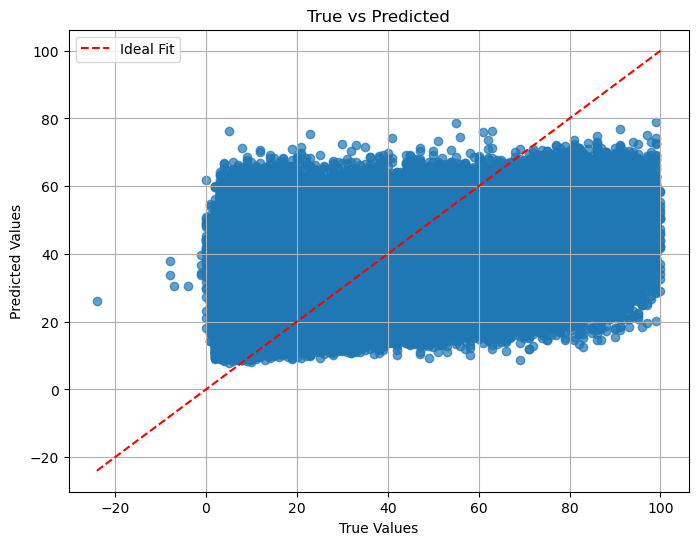

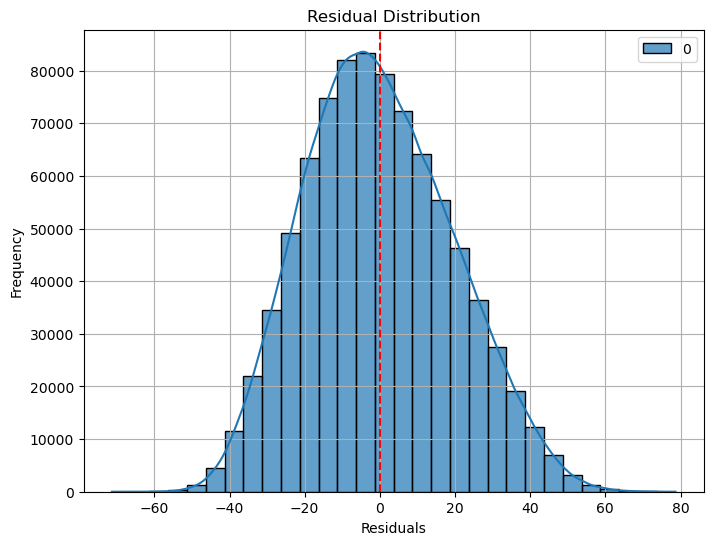

In [27]:
plot_regression_results(y_test_original, y_pred_original, savefig=False, name='lstm-dur')

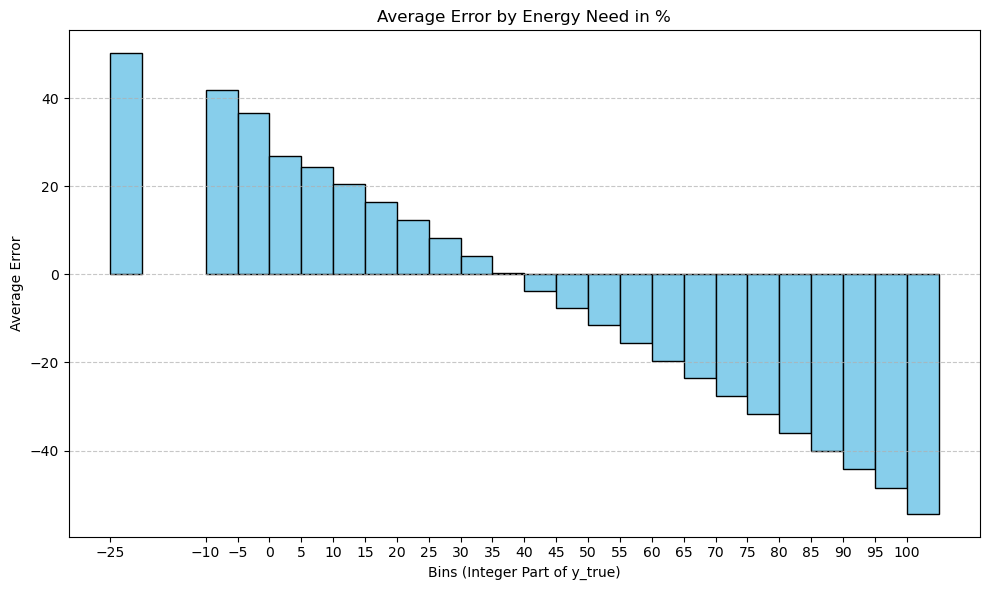

,bin,count,avg_error
0,-25,1.0,50.136557
1,-10,3.0,41.770976
2,-5,5.0,36.560389
3,0,22332.0,26.902662
4,5,65263.0,24.293633
5,10,67616.0,20.399665
6,15,67582.0,16.396249
7,20,69171.0,12.241902
8,25,68820.0,8.183135
9,30,65503.0,4.216769


In [27]:
plot_average_error_by_bins(y_test_original, y_pred_original, bin_size=5, savefig=True, name='lstm-soc')

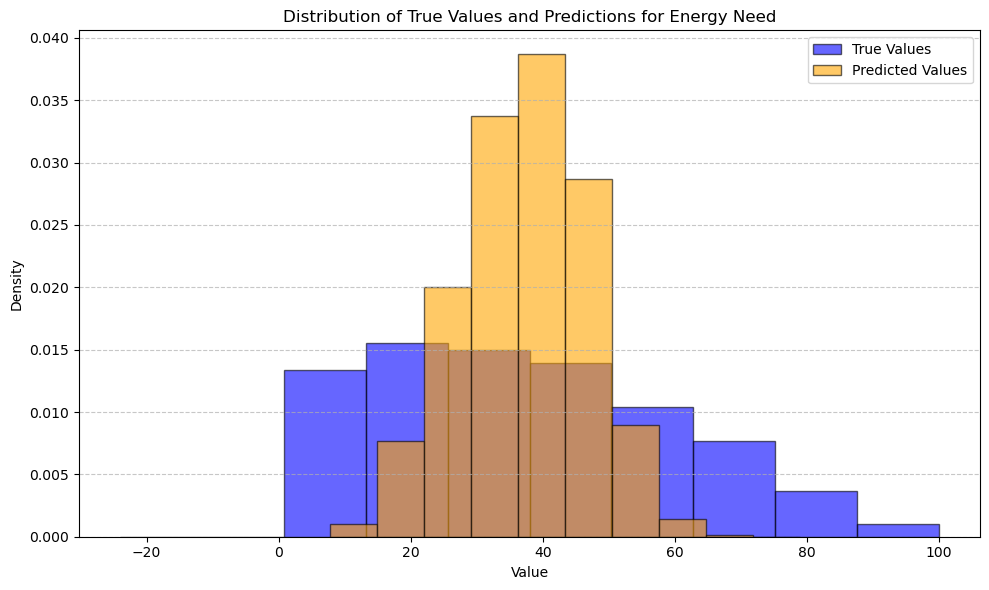

In [76]:
plot_prediction_distribution(y_test_original, y_pred_original, savefig=True, name='lstm-soc')